In [2]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3

LaTex fonts for plots.

In [3]:
LaTexFonts = True
if LaTexFonts:
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

Alfvén and sound speeds.

In [4]:
vA = 4.3
vA2 = vA * vA
cs = 1
cs2 = cs * cs
rho0 = 1
B0 = 1

Domain limits.

In [5]:
capL = 1
xmin = -capL
xmax = capL

In [6]:
kz = 1e-3

Number of grid points.

In [7]:
N = 16

Dedalus setup.

In [8]:
coord = d3.Coordinate('x')
dist = d3.Distributor(coord, dtype=np.complex128)
basis = d3.Legendre(coord, size=N, bounds=(xmin, xmax))		#), dealias=3/2)

Fields.

In [9]:
omega = dist.Field(name='omega')
rho1 = dist.Field(name='rho1', bases=basis)
v1x = dist.Field(name='v1x', bases=basis)
v1z = dist.Field(name='v1z', bases=basis)
B1x = dist.Field(name='B1x', bases=basis)
B1z = dist.Field(name='B1z', bases=basis)

The tau fields are required for all variables and are needed to impose the boundary conditions.

In [10]:
tau_rho1 = dist.Field(name='tau_rho1')
tau_v1x = dist.Field(name='tau_v1x')
tau_v1z = dist.Field(name='tau_v1z')
tau_B1z = dist.Field(name='tau_B1z')

Derivatives with respect to x.

In [11]:
dx = lambda A: d3.Differentiate(A, coord)
lift_basis = basis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)
rho1x = dx(rho1) + lift(tau_rho1)
v1xx = dx(v1x) + lift(tau_v1x)
v1zx = dx(v1z) + lift(tau_v1z)
B1zx = dx(B1z) + lift(tau_B1z)

Problem setup.

In [12]:
problem = d3.EVP([rho1, v1x, v1z, B1x, B1z, tau_rho1, tau_v1x, tau_v1z, tau_B1z], eigenvalue=omega, namespace=locals())
problem.add_equation("omega * rho1 + rho0 * (-v1xx - kz * v1z) = 0")
problem.add_equation("omega * B1x - kz * B0 * v1z = 0")
problem.add_equation("omega * B1z - B0 * v1zx = 0")
problem.add_equation("omega * v1x + cs2 / rho0 * rho1x = 0")
problem.add_equation("omega * v1z - kz * cs2 * rho1 + vA2 * (-kz * B1x + B1zx) = 0")
problem.add_equation("v1x(x=xmin) = 0")
problem.add_equation("v1x(x=xmax) = 0")
problem.add_equation("v1z(x=xmin) = 0")
problem.add_equation("v1z(x=xmax) = 0")

{'eqn': interp(<Field 4521008528>, x=1),
 'LHS': interp(<Field 4521008528>, x=1),
 'RHS': 0,
 'condition': 'True',
 'tensorsig': (),
 'dtype': numpy.complex128,
 'valid_modes': array([ True]),
 'M': 0,
 'L': interp(<Field 4521008528>, x=1),
 'domain': <dedalus.core.domain.Domain at 0x1259a10a0>,
 'matrix_dependence': array([ True]),
 'matrix_coupling': array([ True])}

Solve the eigenproblem.

In [13]:
solver = problem.build_solver()
solver.solve_dense(solver.subproblems[0])
eigenvalues = solver.eigenvalues
Neigenvalues = len(eigenvalues)

2025-04-25 12:50:15,004 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.4e+01/s


In [14]:
def misc_stuff(print_information=True):
    idx_inf = np.where(np.isinf(eigenvalues))

    idx_zero = np.where(np.isclose(eigenvalues, 0, rtol=1e-10))

    idx_constant_eigenfunctions = np.array([], dtype=int)
    for idx in range(Neigenvalues):
#        print(idx, eigenvalues[idx])
        solver.set_state(idx, solver.subsystems[0])
        v1xg = v1x['g'].real
#        print(np.all(np.isclose(v1xg, v1xg[0])))
        if np.all(np.isclose(v1xg, v1xg[0])):
            idx_constant_eigenfunctions = np.append(idx_constant_eigenfunctions, idx)

    idx_unphysical = np.union1d(idx_inf, idx_zero)
    idx_unphysical = np.union1d(idx_unphysical, idx_constant_eigenfunctions)

    idx_physical = np.setdiff1d(range(Neigenvalues), idx_unphysical)

# Sort physical eigensolutions in increasing order of abs(omega)
    dummy = np.argsort(np.abs(eigenvalues[idx_physical]))
    idx_physical_sorted_abs = idx_physical[dummy]
#    dummy = np.argsort(eigenvalues[idx_physical])
#    idx_physical_sorted = idx_physical[dummy]

# For physical solutions, find the number of peaks in the dominant velocity component.
    from scipy.signal import find_peaks
    Npeaks = np.empty(Neigenvalues, dtype=int)
    mode = np.empty(Neigenvalues, dtype="U10")
    for idx in idx_physical_sorted_abs:
        solver.set_state(idx, solver.subsystems[0])
        v1xg = v1x['g']
        v1zg = v1z['g']
        if np.max(np.abs(v1xg)) > np.max(np.abs(v1zg)):
            var = v1xg
            mode[idx] = 'slow'
        else:
            var = v1zg
            mode[idx] = 'fast'
        peaks, _ = find_peaks(np.abs(var))
        Npeaks[idx] = len(peaks)

    if print_information:
        print('Number of eigenvalues ', Neigenvalues)
        print()
        print('Number of infinite eigenvalues ', len(eigenvalues[idx_inf]))
        print('idx_inf ', idx_inf)
#        print('eigenvalues[idx_inf] ', eigenvalues[idx_inf])
        print()
        print('Number of zero eigenvalues ', len(eigenvalues[idx_zero]))
        print('idx_zero ', idx_zero)
#        print('eigenvalues[idx_zero] ', eigenvalues[idx_zero])
        print()
        print('Number of constant eigenfunctions ', len(eigenvalues[idx_constant_eigenfunctions]))
        print('idx_constant_eigenfunctions ', idx_constant_eigenfunctions)
        print()
        print('Number of unphysical eigenvalues ', len(eigenvalues[idx_unphysical]))
        print('idx_unphysical ', idx_unphysical)
#        print('eigenvalues[idx_unphysical] ', eigenvalues[idx_unphysical])
        print('Unphysical eigenvalues')
        print('idx       Re(omega)        Im(omega)')
        for idx in idx_unphysical:
            print(f"{idx:04d}    {eigenvalues[idx].real:+.2e}    {eigenvalues[idx].imag:+.2e}")
        print()
        print('Number of physical eigenvalues ', len(eigenvalues[idx_physical]))
        print('idx_physical ', idx_physical)
#        print('eigenvalues[idx_physical] ', eigenvalues[idx_physical])
#        print('eigenvalues[idx_physical_sorted] ', eigenvalues[idx_physical_sorted])
#        print()
# Print information about eigenvalues.
        print('Physical eigenvalues')
        print('idx     Re(omega)    Im(omega)    Npeaks  mode')
        for idx in idx_physical_sorted_abs:
            print(f"{idx:04d}    {eigenvalues[idx].real:+.2e}      {eigenvalues[idx].imag:+.2e}    {\
                Npeaks[idx]:02d}    {mode[idx]}")
    return idx_physical_sorted_abs, Npeaks, mode

In [15]:
idx_physical_sorted_abs, Npeaks, mode = misc_stuff()

Number of eigenvalues  84

Number of infinite eigenvalues  10
idx_inf  (array([ 1,  2,  3,  4, 78, 79, 80, 81, 82, 83]),)

Number of zero eigenvalues  18
idx_zero  (array([ 0, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76,
       77]),)

Number of constant eigenfunctions  28
idx_constant_eigenfunctions  [ 0  1  2  3  4 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79
 80 81 82 83]

Number of unphysical eigenvalues  28
idx_unphysical  [ 0  1  2  3  4 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79
 80 81 82 83]
Unphysical eigenvalues
idx       Re(omega)        Im(omega)
0000    -0.00e+00    +0.00e+00
0001    +inf    +0.00e+00
0002    +inf    +0.00e+00
0003    +inf    +0.00e+00
0004    +inf    +0.00e+00
0061    +4.63e-15    +8.46e-27
0062    -7.07e-15    +1.31e-26
0063    +5.14e-16    -6.17e-27
0064    +8.33e-16    -5.48e-29
0065    +8.99e-15    +1.42e-25
0066    +6.80e-16    -5.42e-26
0067    -6.00e-16    -1.18e-25
0068    -2.25e-15    +3.70e-24
0069   

Plot the eigenfunctions.

In [16]:
# The purpose of this function is to check the eigensolution with index idx.
# It is expected that both omega and the eigenfunctions are purely real.
def check_eigensolution(idx, rtol_eigenval=1e-12, rtol_eigenfunct=1e-10):
    real_eigensolution = True
    dummy = np.isclose(np.abs(eigenvalues[idx].imag/eigenvalues[idx].real), 0, rtol=rtol_eigenval)
    if not dummy:
        real_eigensolution = False
        print('The eigenvalue is not real with a tolerance of ', rtol_eigenval)
        print(eigenvalues[idx], eigenvalues[idx].imag/eigenvalues[idx].real)

    solver.set_state(idx, solver.subsystems[0])
    variables = [v1x['g'], v1z['g'], rho1['g'], B1x['g'], B1z['g']]
    for i, var in enumerate(variables):
        if not np.all(np.isclose(var.imag / np.max(np.abs(var.real)),
                                 var.imag[0] / np.max(np.abs(var.real)), rtol=rtol_eigenfunct)):
            real_eigensolution = False
            print('The eigenfunction ', i,' is not real with a tolerance of ', rtol_eigenval)
    if real_eigensolution:
        print('The eigenvalue and eigensolutions are real')
    return real_eigensolution

In [17]:
real_eigensolution = check_eigensolution(43)

The eigenvalue and eigensolutions are real


In [18]:
def plot_eigenfunctions(idx_plot, plotIm=False):
    %matplotlib

    if plotIm:
        fig, axs = plt.subplots(5, 2, figsize=(8, 12))
    else:
        fig, axs = plt.subplots(5, 2, figsize=(8, 8))
    plt.rcParams.update({'font.size': 16})
    x = dist.local_grid(basis)
    for idx in idx_plot:
        print(idx, eigenvalues[idx])
#        real_eigensolution = check_eigensolution(idx)
        solver.set_state(idx, solver.subsystems[0])
        v1xg = v1x['g']
        v1zg = v1z['g']
        rho1g = rho1['g']
        B1xg = B1x['g']
        B1zg = B1z['g']
        vars_and_titles = [
            (v1xg, r"$v_{1x}$"),
            (v1zg, r"$v_{1z}$"),
            (rho1g, r"$\rho_1$"),
            (B1xg, r"$B_{1x}$"),
            (B1zg, r"$B_{1z}$")
        ]

        if mode[idx] == 'slow':
            var = v1xg
        else:
            var = v1zg
        idx_max = np.argmax(np.abs(var))
#        var_max = np.max(np.abs(var))
        var_max = np.abs(var[idx_max])

        lambda_ = 2 * (xmax - xmin) / Npeaks[idx]
        kx = 2 * np.pi / lambda_
        print('lambda, kx ', lambda_, kx)
        kx2 = kx * kx
        kz2 = kz * kz
        k2 = kx2 + kz2
        B = - k2*(cs2+vA2)
        C = kx2*k2*cs2*vA2
        omega2f = (-B + np.sqrt(B**2 - 4 * C)) / 2
        omega2s = (-B - np.sqrt(B**2 - 4 * C)) / 2
        omegaf = np.sqrt(omega2f)
        omegas = np.sqrt(omega2s)
        print('omegaf, omegas ', omegaf, omegas)
        print()

        if plotIm:
            for i, (var, var_title) in enumerate(vars_and_titles):
                ax = axs[i, 0]
                ax.plot(x, (var / var_max).real)
                ax.set(xlabel=r"$x$", ylabel=r"$\mathrm{Re}\; $"+var_title)
                ax = axs[i, 1]
                ax.plot(x, (var / var_max).imag, label=f"idx={idx}")
                ax.set(xlabel=r"$x$", ylabel=r"$\mathrm{Im}\; $"+var_title)
                ax.legend()
        else:
            for i, (var, var_title) in enumerate(vars_and_titles):
                ax = axs[i, 0]
                ax.plot(x, (var / var_max).real, label=f"idx={idx}")
                ax.set(xlabel=r"$x$", ylabel=r"$\mathrm{Re}\; $"+var_title)
                ax = axs[i, 1]
#                ax.plot(x, (var / var_max).imag, label=f"idx={idx}")
#                ax.set(xlabel=r"$x$", ylabel=r"$\mathrm{Im}\; $"+var_title)
                ax.axis('off')
#                ax.legend()

    plt.xlim(xmin, xmax)
    plt.tight_layout()
    plt.show()

    return

Using matplotlib backend: module://matplotlib_inline.backend_inline
39 (-1.570796323490834+2.3008568706439558e-27j)
lambda, kx  4.0 1.5707963267948966
omegaf, omegas  6.754425652208414 1.5707963085953682

40 (1.5707963234908424+1.5459508061881516e-27j)
lambda, kx  4.0 1.5707963267948966
omegaf, omegas  6.754425652208414 1.5707963085953682

55 (3.1415926432138788+2.2003681595653873e-33j)
lambda, kx  2.0 3.141592653589793
omegaf, omegas  13.508849133931347 3.141592644490026

57 (-3.141592643213882-3.244275504879015e-35j)
lambda, kx  2.0 3.141592653589793
omegaf, omegas  13.508849133931347 3.141592644490026



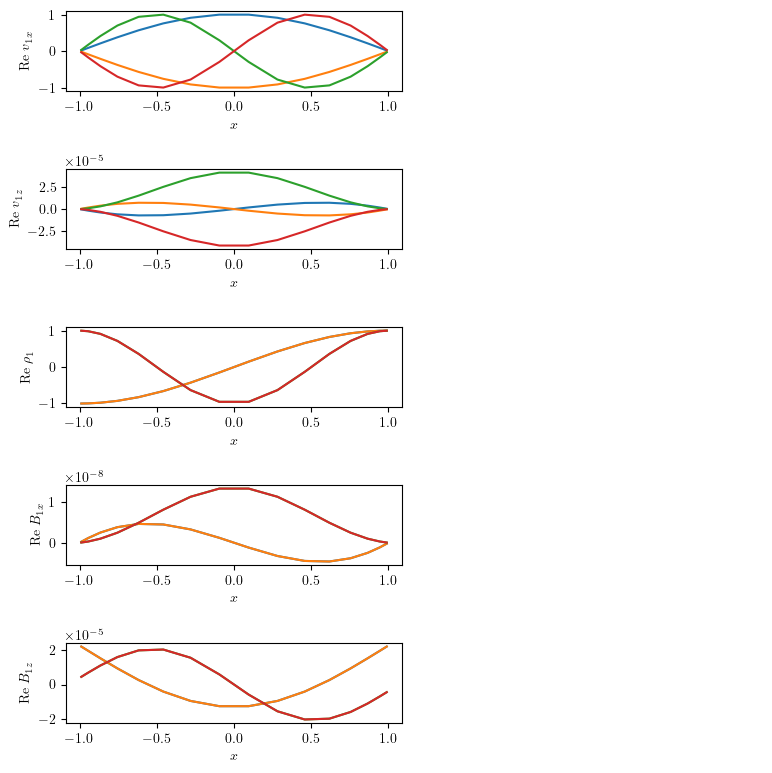

In [19]:
idx_plot = idx_physical_sorted_abs[0:4]
plot_eigenfunctions(idx_plot)

In [20]:
kz_list = np.linspace(0, 5, 50)
kz = dist.Field()

problem = d3.EVP([rho1, v1x, v1z, B1x, B1z, tau_rho1, tau_v1x, tau_v1z, tau_B1z], eigenvalue=omega, namespace=locals())
problem.add_equation("omega * rho1 + rho0 * (-v1xx - kz * v1z) = 0")
problem.add_equation("omega * B1x - kz * B0 * v1z = 0")
problem.add_equation("omega * B1z - B0 * v1zx = 0")
problem.add_equation("omega * v1x + cs2 / rho0 * rho1x = 0")
problem.add_equation("omega * v1z - kz * cs2 * rho1 + vA2 * (-kz * B1x + B1zx) = 0")
problem.add_equation("v1x(x=xmin) = 0")
problem.add_equation("v1x(x=xmax) = 0")
problem.add_equation("v1z(x=xmin) = 0")
problem.add_equation("v1z(x=xmax) = 0")

solver = problem.build_solver()
evals = []
N_evals_keep = 12
for kz_ in kz_list:
    kz['g'] = kz_
    solver.solve_dense(solver.subproblems[0], rebuild_matrices=True)
    eigenvalues = solver.eigenvalues
    Neigenvalues = len(eigenvalues)
    idx_physical_sorted_abs, Npeaks, mode = misc_stuff(print_information=False)
    evals.append(eigenvalues[idx_physical_sorted_abs[0:N_evals_keep]])
evals = np.array(evals)

2025-04-25 12:51:08,068 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s


2025-04-25 12:51:08,137 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.0e+01/s
2025-04-25 12:51:08,198 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.5e+01/s
2025-04-25 12:51:08,260 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.2e+01/s
2025-04-25 12:51:08,321 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.7e+01/s
2025-04-25 12:51:08,378 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.5e+01/s
2025-04-25 12:51:08,434 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+01/s
2025-04-25 12:51:08,491 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.5e+01/s
2025-04-25 12:51:08,551 subsystems 0/1 INFO :: Building subproblem matrices 

In [21]:
print(kz['g'])
print('kz[''g''].shape ', kz['g'].shape)
print('kz_list.shape ', kz_list.shape)
print('evals.shape ', evals.shape)
print(evals[:, :].shape)
print(evals[:,0])
print()
print(evals)

[5.+0.j]
kz[g].shape  (1,)
kz_list.shape  (50,)
evals.shape  (50, 12)
(50, 12)
[ 1.57079633+0.00000000e+00j  1.57076196-1.14233271e-15j
 -1.5706593 -1.28016266e-16j  1.57048963+8.18910667e-18j
  1.57025506+1.70578905e-18j -1.56995845+4.79774360e-28j
  1.56960332+1.01109184e-18j -1.56919374+4.61299081e-16j
 -1.56873423+4.02136669e-17j -1.56822963+2.48238345e-18j
  1.567685  +1.19926763e-17j  1.56710546+4.38877842e-17j
  1.56649616+7.54671553e-20j -1.56586211+8.66645774e-17j
  1.56520814-3.32158179e-17j  1.56453887-3.89678914e-17j
  1.56385857+5.64111223e-19j  1.56317121-5.72532959e-16j
  1.56248042-2.80438901e-15j -1.56178944-5.25542243e-16j
  1.56110116-6.07554202e-16j  1.56041812-3.25921064e-28j
  1.55974252+3.19315752e-16j  1.55907624-5.50195086e-18j
 -1.55842085+1.07520929e-16j  1.55777767+1.15707872e-15j
 -1.55714774-1.90610004e-15j  1.5565319 -2.73610139e-16j
 -1.55593078-4.70305377e-16j  1.55534483-6.16108726e-20j
  1.55477436+3.29352166e-17j -1.55421953+8.70449784e-17j
 -1.55368

In [22]:
def onclick(event):
    print('%s click: button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %
          ('double' if event.dblclick else 'single', event.button,
           event.x, event.y, event.xdata, event.ydata))

Using matplotlib backend: module://matplotlib_inline.backend_inline


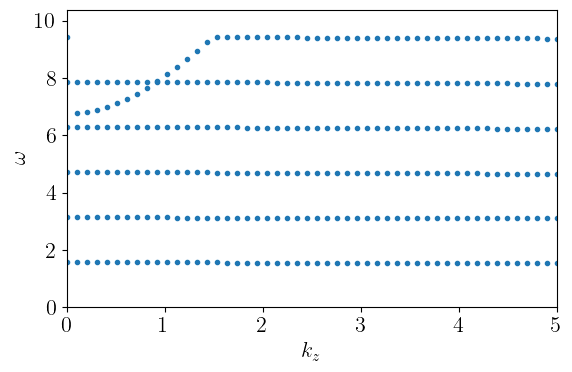

In [23]:
%matplotlib
fig = plt.figure(figsize=(6, 4))
plt.plot(kz_list, evals[:, :].real, '.', c='C0')
#plt.plot(q_list, evals[:, 1::2], '.-', c='C1')
plt.xlim(kz_list.min(), kz_list.max())
plt.ylim(bottom=0)
plt.xlabel(r"$k_z$")
plt.ylabel(r"$\omega$")
#plt.title("Mathieu eigenvalues")
plt.tight_layout()
plt.show()

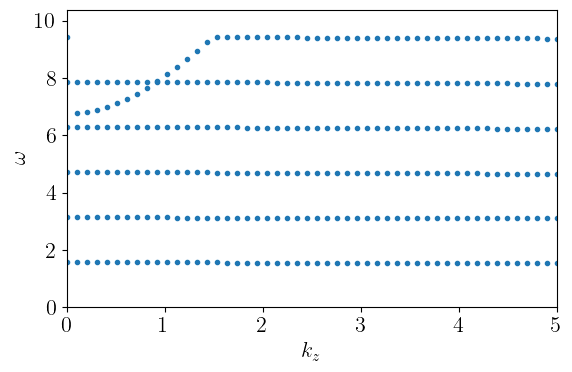

In [26]:
%matplotlib inline
fig = plt.figure(figsize=(6, 4))
plt.plot(kz_list, evals[:, :].real, '.', c='C0')
#plt.plot(q_list, evals[:, 1::2], '.-', c='C1')
plt.xlim(kz_list.min(), kz_list.max())
plt.ylim(bottom=0)
plt.xlabel(r"$k_z$")
plt.ylabel(r"$\omega$")
#plt.title("Mathieu eigenvalues")
plt.tight_layout()
cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()

In [25]:
fig.canvas.mpl_disconnect(cid)